# School analysis
Testing out functions in schools.py, and looking at centrality over time

## Libaries

In [122]:
import schools as s
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns

In [9]:
%matplotlib inline

## Import data

In [2]:
students = s.get_all_students()

In [3]:
students.head()

,Unnamed: 0,id,student_id,student_name,student_school,student_year,student_descendants,advisor_name,advisor_school,advisor_year,advisor_year_dec,student_year_dec
0,0,233136,233138,"Mogstad, Magne",Universitetet i Oslo,2008,1,"Aaberge, Rolf",Universitetet i Oslo,1976,1970s,2000s
1,1,13670,106100,"Anagnostakis, Christopher",Yale University,1984,,"Aaboe, Asger",Brown University,1957,1950s,1980s
2,2,13670,122878,"Britton, John",Yale University,1966,,"Aaboe, Asger",Brown University,1957,1950s,1960s
3,3,13670,122880,"Slotsky, Alice",Yale University,1992,1,"Aaboe, Asger",Brown University,1957,1950s,1990s
4,4,13670,122881,"Swerdlow, Noel",Yale University,1968,,"Aaboe, Asger",Brown University,1957,1950s,1960s


## Analysis

### Eigenvector centrality by decade

In [114]:
def top_degree_subgraph(dg, weight_col_name, n):
    degrees =  pd.DataFrame(list(nx.degree(dg, weight = weight_col_name)), columns = ["node", "degree"])
    top_n_nodes = degrees.sort_values("degree", ascending = False).iloc[:n]["node"].values
    return dg.subgraph(top_n_nodes)

In [4]:
decades = [str(1950 + 10 * i) + "s" for i in range(7)]

In [112]:
decade_school_digraphs = [{
    "decade": dec,
    "school_dg": s.make_school_digraph(students.query("student_year_dec == '{}'".format(dec)))} for dec in decades]

In [171]:
for dec_s_dg in decade_school_digraphs:
    dec_s_dg["school_sg"] = top_degree_subgraph(dec_s_dg["school_dg"], "weight", 15)
    dec_s_dg["deg"] = dict(dec_s_dg["school_sg"].out_degree(weight = "weight"))
    dec_s_dg["cent"] = nx.eigenvector_centrality(dec_s_dg["school_sg"].reverse(), weight='weight', max_iter = 1000)

In [157]:
def draw_graph_layout_cent(graph, layout, ax, cent = None):
    """
    draw the graph with the given layout on the given axis
    """
    cent_list = [200 * cent[k] if cent else 10 for k, v in layout.items()]
    ax.scatter([v[0] for k, v in layout.items()], [v[1] for k, v in layout.items()], s = cent_list)
    for k, v in layout.items():
        ax.annotate(k, v, xytext = (5, 5), textcoords = "offset points", fontsize = 10 + 5 * cent[k] if cent else 12)
    for e in [e for e in graph.edges]:
        ax.plot([layout[i][0] for i in e], [layout[i][1] for i in e], c = "steelblue", lw = 0.1)

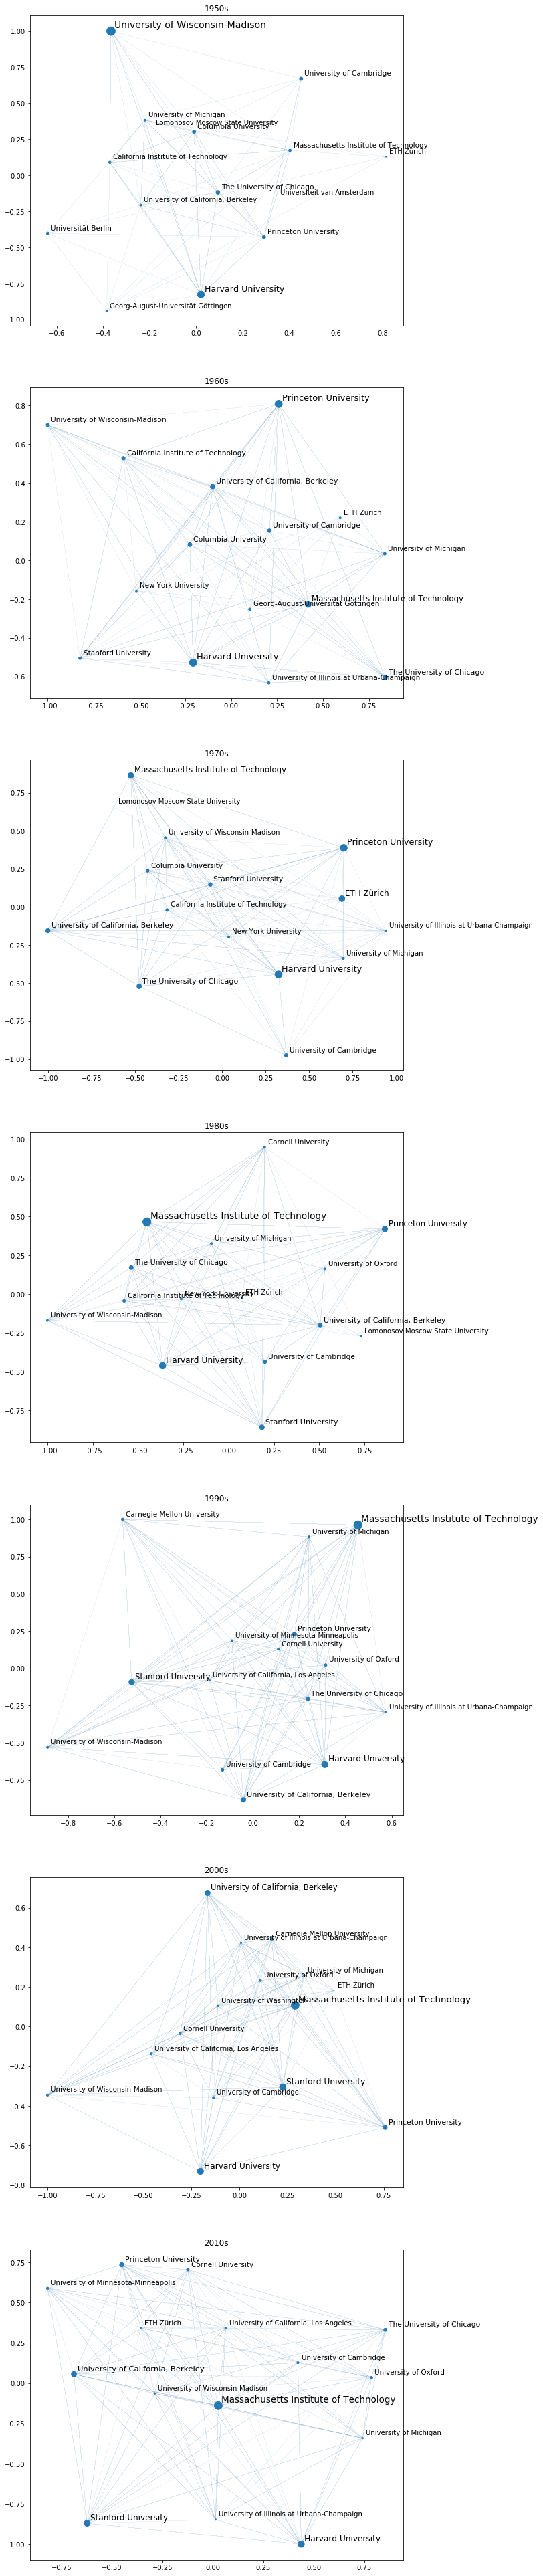

In [158]:
fig, ax = plt.subplots(figsize = (10, 10 * len(decades)), nrows = len(decades))
for i, d in enumerate(decade_school_digraphs):
    layout = nx.kamada_kawai_layout(d["school_sg"])
    draw_graph_layout_cent(d["school_sg"], layout, ax[i], cent = d["cent"])
    ax[i].set_title(d["decade"])

### Eigenvector centrality over time

In [159]:
all_cent = pd.concat(
    [pd.DataFrame([{"school": k, "cent": v, "decade": d["decade"]} for k, v in d["cent"].items()]) for d in decade_school_digraphs])

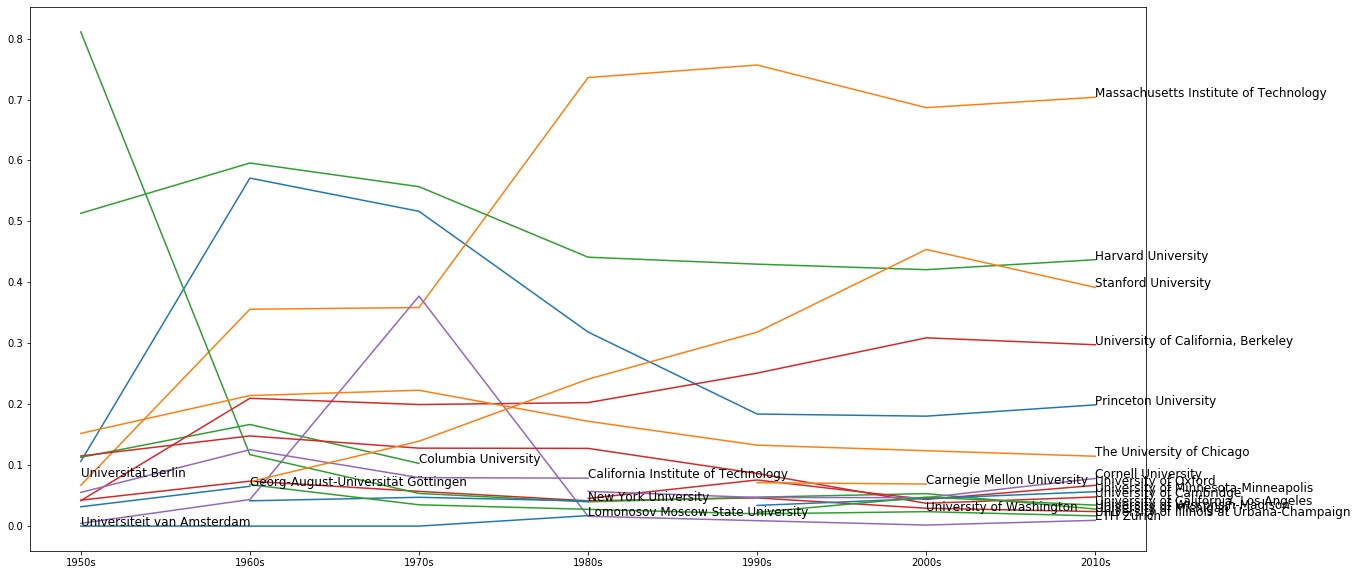

In [160]:
fig, ax = plt.subplots(figsize = (20, 10))
for i, school in enumerate(all_cent.school.unique()):
    school_cent = all_cent.query("school == '{}'".format(school))
    ax.plot(school_cent["decade"], school_cent["cent"], c = sns.color_palette()[i % 5])
    ax.annotate(school, [school_cent.iloc[-1]["decade"], school_cent.iloc[-1]["cent"]], fontsize = 12)

### Degree over time

In [173]:
all_deg = pd.concat(
    [pd.DataFrame([{"school": k, "deg": v, "decade": d["decade"]} for k, v in d["deg"].items()]) for d in decade_school_digraphs])

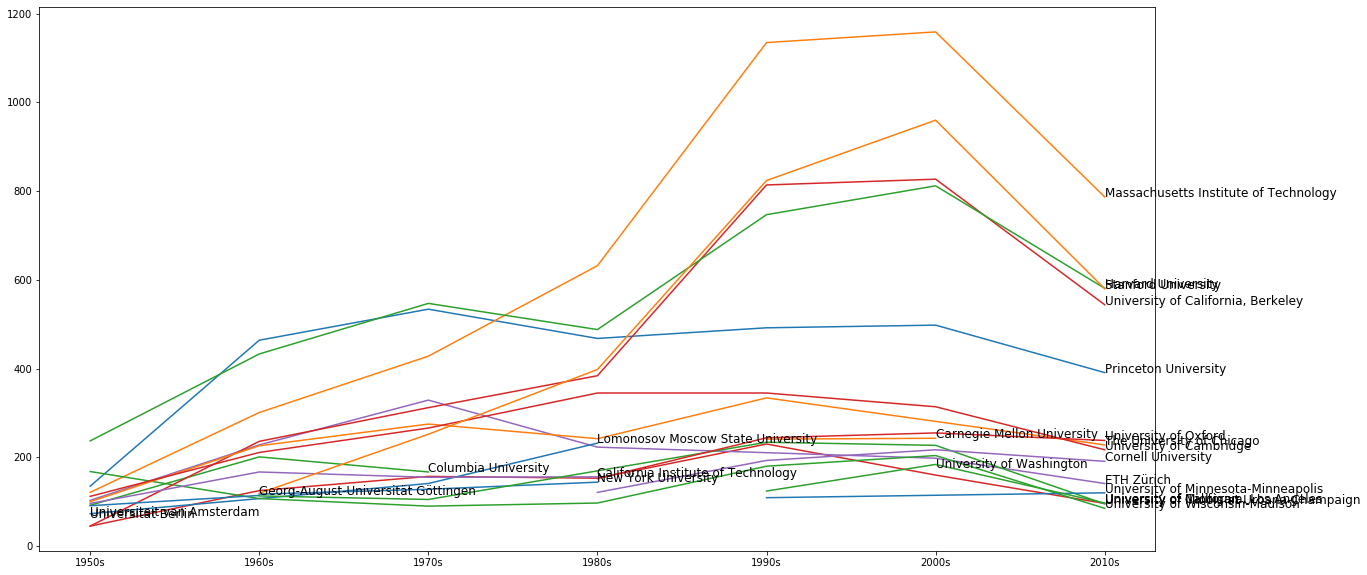

In [174]:
fig, ax = plt.subplots(figsize = (20, 10))
for i, school in enumerate(all_cent.school.unique()):
    school_deg = all_deg.query("school == '{}'".format(school))
    ax.plot(school_deg["decade"], school_deg["deg"], c = sns.color_palette()[i % 5])
    ax.annotate(school, [school_deg.iloc[-1]["decade"], school_deg.iloc[-1]["deg"]], fontsize = 12)